# 7. Training at Scale

**Gradient accumulation and validation for stable training**

Building the transformer architecture is only half the battle. To train it effectively, we need techniques that make training stable, prevent overfitting, and work within the constraints of hobby-scale hardware.

This section covers two critical techniques: **gradient accumulation** and **validation splits**.

## The Challenge: Small Batches, Noisy Training

**What is a batch?** During training, we process multiple examples together in a "batch." The model makes predictions for all examples, we compute the average loss, then calculate gradients and update weights. Larger batches give us more stable gradient estimates because we're averaging over more examples.

**The problem with small batches:** On hobby hardware (like an M1 Mac or consumer GPU), we're limited to small batches—typically just 8 sequences at a time. Small batches lead to *noisy gradients*: each batch gives a slightly different signal about which direction to update the weights, causing erratic training.

**Memory bottleneck:** Why can't we just use bigger batches? Each example requires storing activations in memory for the backward pass. M1 Macs have ~8GB unified memory, and a batch of 8 sequences already uses ~4GB. Doubling to 16 would run out of memory!

## Gradient Accumulation: Large Batches Without the Memory Cost

**The key insight:** We don't need to process all examples simultaneously! Gradient accumulation lets us simulate large batch sizes by accumulating gradients over multiple small batches before updating weights.

**How it works:**

1. **Process batch 1:** Forward pass → Loss → Backward pass → Store gradients (don't update yet!)
2. **Process batch 2:** Forward pass → Loss → Backward pass → *Add* gradients to stored ones
3. **Repeat** for N batches (e.g., 16 times)
4. **Update weights:** Use the accumulated (averaged) gradients

**Why this works mathematically:** Gradients are linear, so averaging gradients from N separate batches gives the same result as computing the gradient on one large batch:

$$\nabla(L_1 + L_2 + ... + L_n) = \nabla L_1 + \nabla L_2 + ... + \nabla L_n$$

By accumulating gradients over 16 batches of 8 sequences each, we get gradients equivalent to a batch of 128 sequences—16× more stable!—while only ever holding 8 sequences in memory.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple model for demonstration
model = nn.Linear(64, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Simulated data
def get_batch():
    x = torch.randn(8, 64)  # batch_size=8
    y = torch.randint(0, 10, (8,))
    return x, y

In [2]:
# WITHOUT accumulation (noisy - updates every batch)
print("Training WITHOUT gradient accumulation:")
print("  Each batch = 8 examples")
print("  Updates every batch (noisy gradients)\n")

for step in range(4):
    x, y = get_batch()
    loss = F.cross_entropy(model(x), y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"  Step {step}: loss = {loss.item():.4f}, updated weights")

Training WITHOUT gradient accumulation:
  Each batch = 8 examples
  Updates every batch (noisy gradients)

  Step 0: loss = 2.5355, updated weights
  Step 1: loss = 2.4355, updated weights
  Step 2: loss = 2.5221, updated weights
  Step 3: loss = 2.4037, updated weights


In [3]:
# WITH accumulation (stable - updates every N batches)
print("Training WITH gradient accumulation (16 steps):")
print("  Each batch = 8 examples")
print("  Effective batch = 8 × 16 = 128 examples")
print("  Updates every 16 batches (stable gradients)\n")

accumulation_steps = 16
optimizer.zero_grad()

for step in range(32):
    x, y = get_batch()
    loss = F.cross_entropy(model(x), y)
    loss = loss / accumulation_steps  # Scale for correct averaging
    loss.backward()                   # Accumulate gradients
    
    if (step + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        print(f"  Step {step}: accumulated loss = {loss.item() * accumulation_steps:.4f}, updated weights")
    else:
        print(f"  Step {step}: accumulated loss = {loss.item() * accumulation_steps:.4f}, accumulating...")

Training WITH gradient accumulation (16 steps):
  Each batch = 8 examples
  Effective batch = 8 × 16 = 128 examples
  Updates every 16 batches (stable gradients)

  Step 0: accumulated loss = 2.5846, accumulating...
  Step 1: accumulated loss = 2.3174, accumulating...
  Step 2: accumulated loss = 2.3640, accumulating...
  Step 3: accumulated loss = 2.6422, accumulating...
  Step 4: accumulated loss = 2.5566, accumulating...
  Step 5: accumulated loss = 2.3445, accumulating...
  Step 6: accumulated loss = 2.1034, accumulating...
  Step 7: accumulated loss = 2.4424, accumulating...
  Step 8: accumulated loss = 2.1125, accumulating...
  Step 9: accumulated loss = 2.3367, accumulating...
  Step 10: accumulated loss = 2.6434, accumulating...
  Step 11: accumulated loss = 2.6670, accumulating...
  Step 12: accumulated loss = 2.9747, accumulating...
  Step 13: accumulated loss = 2.4417, accumulating...
  Step 14: accumulated loss = 2.4635, accumulating...
  Step 15: accumulated loss = 2.2417,

## Validation: Detecting Overfitting

### The Problem: Memorization vs. Learning

Imagine a student preparing for an exam. They could:

- **Memorize answers** to practice problems → Fails on new problems (overfitting)
- **Learn concepts** from practice problems → Succeeds on new problems (good generalization)

The same happens with neural networks. As training progresses, the model might start memorizing the training data instead of learning general patterns. This is called **overfitting**.

### The Solution: Validation Split

We set aside 10% of our data that the model *never* sees during training. After each epoch, we evaluate on this "validation" data. If the model is truly learning patterns, it should perform well on both training and validation data.

## How to Interpret the Curves

### Good Training
```
Train: 5.0 → 4.0 → 3.0
Val:   5.2 → 4.2 → 3.2
```
Both losses decreasing together. Model is learning general patterns!

### Underfitting
```
Train: 5.0 → 4.8 → 4.7
Val:   5.2 → 5.0 → 4.9
```
Both losses barely improving. Model is too simple or needs more training.

### Overfitting
```
Train: 5.0 → 3.0 → 1.5
Val:   5.2 → 3.5 → 4.0  ← Going up!
```
Training loss decreasing but validation increasing. Model is memorizing!

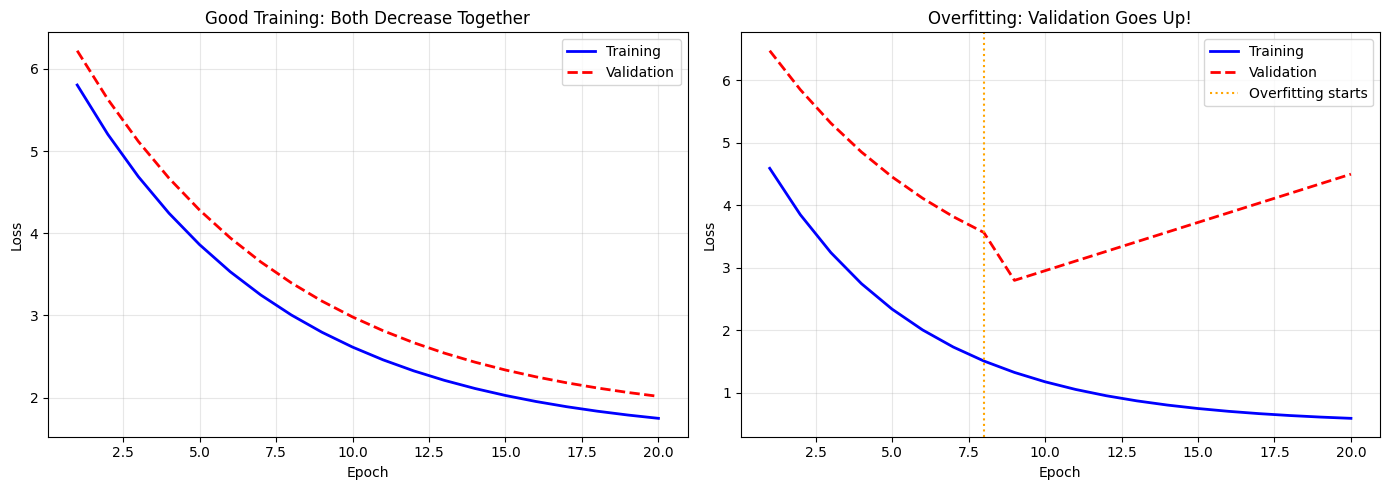

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate training curves
epochs = np.arange(1, 21)

# Good training
train_good = 5.0 * np.exp(-0.15 * epochs) + 1.5
val_good = 5.2 * np.exp(-0.14 * epochs) + 1.7

# Overfitting
train_overfit = 5.0 * np.exp(-0.2 * epochs) + 0.5
val_overfit = np.concatenate([5.2 * np.exp(-0.15 * epochs[:8]) + 2.0, 
                              np.linspace(2.8, 4.5, 12)])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Good training
axes[0].plot(epochs, train_good, 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, val_good, 'r--', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Good Training: Both Decrease Together')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overfitting
axes[1].plot(epochs, train_overfit, 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, val_overfit, 'r--', label='Validation', linewidth=2)
axes[1].axvline(x=8, color='orange', linestyle=':', label='Overfitting starts')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Overfitting: Validation Goes Up!')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Training loop with validation
def training_loop_with_validation(model, train_data, val_data, epochs):
    """
    Pseudocode for training with validation monitoring.
    """
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_data:
            loss = compute_loss(model, batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
        
        # Validation phase (no gradient updates!)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_data:
                loss = compute_loss(model, batch)
                val_loss += loss.item()
        
        print(f"Epoch {epoch}: Train={train_loss:.2f}, Val={val_loss:.2f}")
        
        # Check for overfitting
        if val_loss > train_loss * 1.3:
            print("Warning: Possible overfitting!")

print("Training loop structure (pseudocode above)")
print("\nKey points:")
print("  - model.train() enables dropout, batch norm training mode")
print("  - model.eval() disables them for evaluation")
print("  - torch.no_grad() prevents gradient computation (faster)")

Training loop structure (pseudocode above)

Key points:
  - model.train() enables dropout, batch norm training mode
  - model.eval() disables them for evaluation
  - torch.no_grad() prevents gradient computation (faster)


## Expected Improvements

With gradient accumulation and validation:

- **20-30% lower final loss** due to stable training
- **Smoother training curves** that are easier to debug
- **Confidence in generalization** by monitoring validation
- **Early stopping** when validation stops improving
- **Works on hobby hardware** without expensive GPUs

## Next: KV-Cache

Now we'll look at how to speed up text generation by caching key-value pairs during inference.